# Assignment 1: Neural Machine Translation

Welcome to the first assignment of Course 4. Here, you will build an English-to-Portuguese neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention. Machine translation is an important task in natural language processing and could be useful not only for translating one language to another but also for word sense disambiguation (e.g. determining whether the word "bank" refers to the financial bank, or the land alongside a river). Implementing this using just a Recurrent Neural Network (RNN) with LSTMs can work for short to medium length sentences but can result in vanishing gradients for very long sequences. To help with this, you will be adding an attention mechanism to allow the decoder to access all relevant parts of the input sentence regardless of its length. By completing this assignment, you will:

- Implement an encoder-decoder system with attention
- Build the NMT model from scratch using Tensorflow
- Generate translations using greedy and Minimum Bayes Risk (MBR) decoding

## Table of Contents
- [1 - Data Preparation](#1)
- [2 - NMT model with attention](#2)
    - [Exercise 1 - Encoder](#ex1)
    - [Exercise 2 - CrossAttention](#ex2)
    - [Exercise 3 - Decoder](#ex3)    
    - [Exercise 4 - Translator](#ex4)
- [3 - Training](#3)
- [4 - Using the model for inference ](#4)
    - [Exercise 5 - translate](#ex5)
- [5 - Minimum Bayes-Risk Decoding](#5)
    - [Exercise 6 - rouge1_similarity](#ex6)
    - [Exercise 7 - average_overlap](#ex7)


In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Setting this env variable prevents TF warnings from showing up

import numpy as np
import tensorflow as tf
from collections import Counter
from utils import (sentences, train_data, val_data, english_vectorizer, portuguese_vectorizer, 
                   masked_loss, masked_acc, tokens_to_text)

In [8]:
import w1_unittest

<a name="1"></a>
## 1. Data Preparation

The text pre-processing bits have already been taken care of (if you are interested in this be sure to check the `utils.py` file). The steps performed can be summarized as:

- Reading the raw data from the text files
- Cleaning the data (using lowercase, adding space around punctuation, trimming whitespaces, etc)
- Splitting it into training and validation sets
- Adding the start-of-sentence and end-of-sentence tokens to every sentence
- Tokenizing the sentences
- Creating a Tensorflow dataset out of the tokenized sentences

Take a moment to inspect the raw sentences:

In [9]:
portuguese_sentences, english_sentences = sentences

print(f"English (to translate) sentence:\n\n{english_sentences[-5]}\n")
print(f"Portuguese (translation) sentence:\n\n{portuguese_sentences[-5]}")

English (to translate) sentence:

No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.

Portuguese (translation) sentence:

Não importa o quanto você tenta convencer os outros de que chocolate é baunilha, ele ainda será chocolate, mesmo que você possa convencer a si mesmo e poucos outros de que é baunilha.


You don't have much use for the raw sentences so delete them to save memory:

In [10]:
del portuguese_sentences
del english_sentences
del sentences

Notice that you imported an `english_vectorizer` and a `portuguese_vectorizer` from `utils.py`. These were created using [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) and they provide interesting features such as ways to visualize the vocabulary and convert text into tokenized ids and vice versa. In fact, you can inspect the first ten words of the vocabularies for both languages:

In [11]:
print(f"First 10 words of the english vocabulary:\n\n{english_vectorizer.get_vocabulary()[:10]}\n")
print(f"First 10 words of the portuguese vocabulary:\n\n{portuguese_vectorizer.get_vocabulary()[:10]}")

First 10 words of the english vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'i', 'to', 'you', 'the']

First 10 words of the portuguese vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'que', 'o', 'nao', 'eu']


Notice that the first 4 words are reserved for special words. In order, these are:

- the empty string
- a special token to represent an unknown word
- a special token to represent the start of a sentence
- a special token to represent the end of a sentence

You can see how many words are in a vocabulary by using the `vocabulary_size` method:

In [12]:
# Size of the vocabulary
vocab_size = portuguese_vectorizer.vocabulary_size()

print(f"Portuguese vocabulary is made up of {vocab_size} words")

Portuguese vocabulary is made up of 12000 words


You can define [tf.keras.layers.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) objects that will help you map from words to ids and vice versa. Do this for the portuguese vocabulary since this will be useful later on when you decode the predictions from your model:

In [15]:
# This helps you convert from words to ids
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(), 
    mask_token="", 
    oov_token="[UNK]"
)

# This helps you convert from ids to words
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]",
    invert=True,
)

Try it out for the special tokens and a random word:

In [16]:
unk_id = word_to_id("[UNK]")
sos_id = word_to_id("[SOS]")
eos_id = word_to_id("[EOS]")
baunilha_id = word_to_id("baunilha")

print(f"The id for the [UNK] token is {unk_id}")
print(f"The id for the [SOS] token is {sos_id}")
print(f"The id for the [EOS] token is {eos_id}")
print(f"The id for baunilha (vanilla) is {baunilha_id}")

The id for the [UNK] token is 1
The id for the [SOS] token is 2
The id for the [EOS] token is 3
The id for baunilha (vanilla) is 7079


Finally take a look at how the data that is going to be fed to the neural network looks like. Both `train_data` and `val_data` are of type `tf.data.Dataset` and are already arranged in batches of 64 examples. To get the first batch out of a tf dataset you can use the `take` method. To get the first example out of the batch you can slice the tensor and use the `numpy` method for nicer printing:

In [17]:
for (to_translate, sr_translation), translation in train_data.take(1):
    print(f"Tokenized english sentence:\n{to_translate[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence (shifted to the right):\n{sr_translation[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence:\n{translation[0, :].numpy()}\n\n")

Tokenized english sentence:
[   2  210    9  146  123   38    9 1672    4    3    0    0    0    0]


Tokenized portuguese sentence (shifted to the right):
[   2 1085    7  128   11  389   37 2038    4    0    0    0    0    0
    0]


Tokenized portuguese sentence:
[1085    7  128   11  389   37 2038    4    3    0    0    0    0    0
    0]




There are a couple of important details to notice.

- Padding has already been applied to the tensors and the value used for this is 0
- Each example consists of 3 different tensors:
    - The sentence to translate
    - The shifted-to-the-right translation
    - The translation
    
The first two can be considered as the features, while the third one as the target. By doing this your model can perform Teacher Forcing as you saw in the lectures.

Now it is time to begin coding!

<a name="2"></a>
## 2. NMT model with attention

The model you will build uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) takes in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. You can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. You can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.

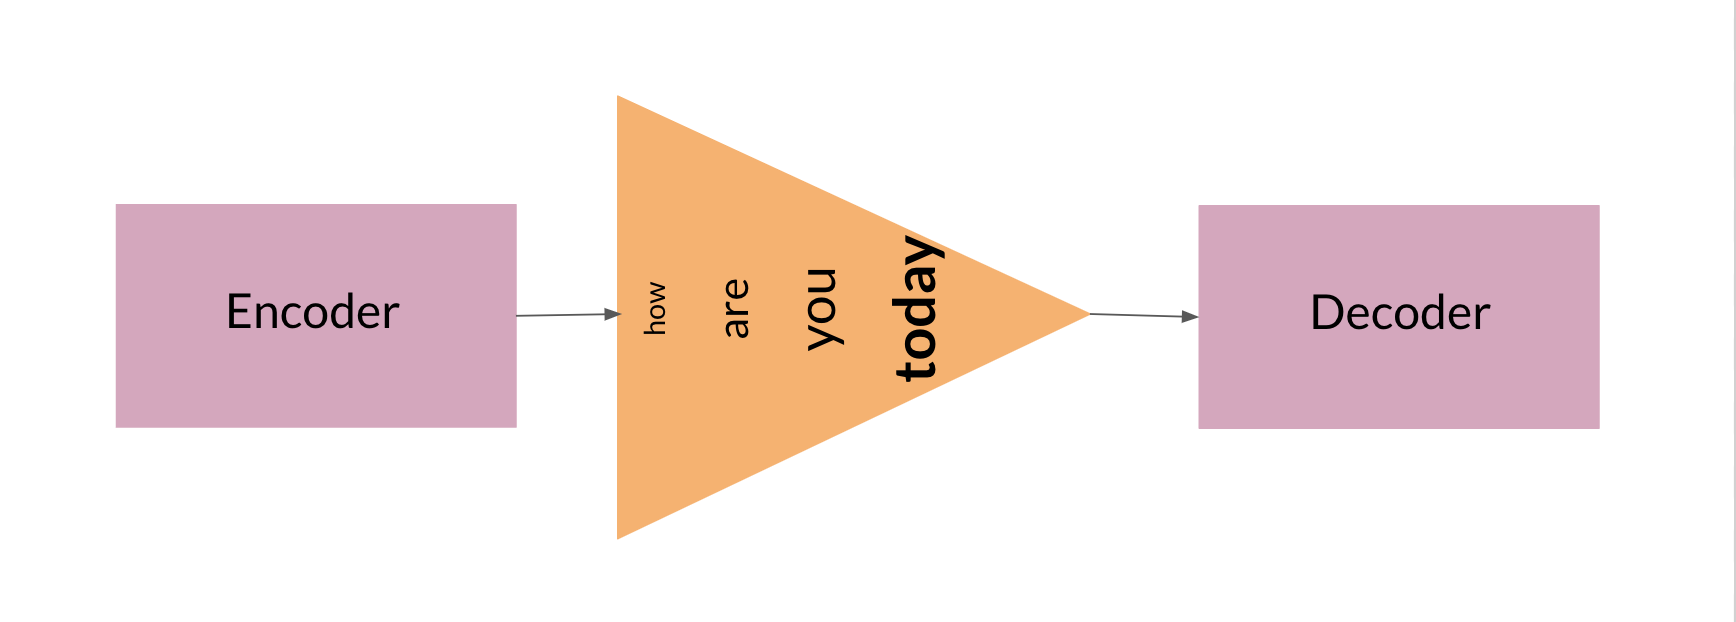

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "como" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "como" (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. As a result of training, the model might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "você". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

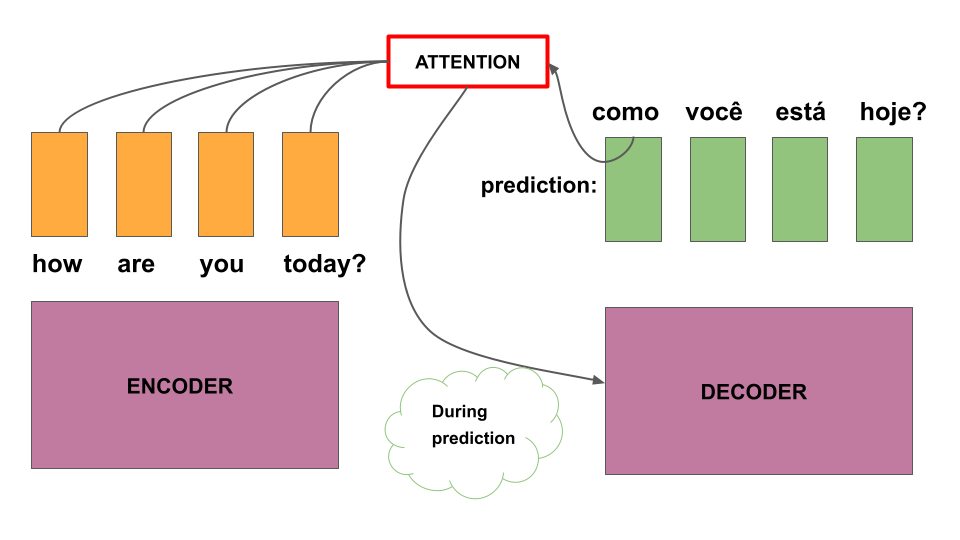


There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

You will dive deeper into this equation in the next week but for now, you can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and you'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

You will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code. 

First you will define two important global variables:

- The size of the vocabulary
- The number of units in the LSTM layers (the same number will be used for all LSTM layers)

In [18]:
VOCAB_SIZE = 12000
UNITS = 256

<a name="ex1"></a>
## Exercise 1 - Encoder

Your first exercise is to code the encoder part of the neural network. For this, complete the `Encoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the encoder and then use these sublayers during the forward pass (the `call` method).

The encoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
    
+ [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In TF you can implement bidirectional behaviour for RNN-like layers. This part is already taken care of but you will need to specify the appropriate type of layer as well as its parameters. In particular you need to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter.


You need to define the forward pass using the syntax of TF's [functional API](https://www.tensorflow.org/guide/keras/functional_api). What this means is that you chain function calls together to define your network like this:

```python
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
```

In [20]:
# GRADED CLASS: Encoder
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Encoder, self).__init__()

        ### START CODE HERE ###

        self.embedding = tf.keras.layers.Embedding(  
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        self.rnn = tf.keras.layers.Bidirectional(  
            merge_mode="sum",  
            layer=tf.keras.layers.LSTM(
                units=units,
                return_sequences=True
            ),  
        )  

        ### END CODE HERE ###

    def call(self, context):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): The sentence to translate

        Returns:
            tf.Tensor: Encoded sentence to translate
        """

        ### START CODE HERE ###

        # Pass the context through the embedding layer
        x = self.embedding(context)

        # Pass the output of the embedding through the RNN
        x = self.rnn(x)

        ### END CODE HERE ###

        return x

In [21]:
# Do a quick check of your implementation

# Create an instance of your class
encoder = Encoder(VOCAB_SIZE, UNITS)

# Pass a batch of sentences to translate from english to portuguese
encoder_output = encoder(to_translate)

print(f'Tensor of sentences in english has shape: {to_translate.shape}\n')
print(f'Encoder output has shape: {encoder_output.shape}')

Tensor of sentences in english has shape: (64, 14)

Encoder output has shape: (64, 14, 256)


##### __Expected Output__

```
Tensor of sentences in english has shape: (64, 14)

Encoder output has shape: (64, 14, 256)
```

In [22]:
# Test your code!

w1_unittest.test_encoder(Encoder)

 All tests passed!


<a name="ex2"></a>
## Exercise 2 - CrossAttention

Your next exercise is to code the layer that will perform cross attention between the original sentences and the translations. For this, complete the `CrossAttention` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers and then use these sublayers during the forward pass (the `call` method). For this particular case some of these bits are already taken care of.

The cross attention consists of the following layers:

- [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). For this layer you need to define the appropriate `key_dim`, which is the size of the key and query tensors. You will also need to set the number of heads to 1 since you aren't implementing multi head attention but attention between two tensors. The reason why this layer is preferred over [Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) is that it allows simpler code during the forward pass.
    
A couple of things to notice:
- You need a way to pass both the output of the attention alongside the shifted-to-the-right translation (since this cross attention happens in the decoder side). For this you will use an [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) layer so that the original dimension is preserved, which would not happen if you use something like a [Concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) layer.

+ Layer normalization is also performed for better stability of the network by using a [LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) layer.

- You don't need to worry about these last steps as these are already solved.



In [31]:
# GRADED CLASS: CrossAttention
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """Initializes an instance of this class

        Args:
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        ### START CODE HERE ###

        self.mha = tf.keras.layers.MultiHeadAttention(
            key_dim=units,
            num_heads=1  # Adjust the number of heads based on your requirements
        )

        ### END CODE HERE ###

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, context, target):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The embedded shifted-to-the-right translation

        Returns:
            tf.Tensor: Cross attention between context and target
        """
        ### START CODE HERE ###

        # Call the MH attention by passing in the query and value
        # For this case, the query should be the translation, and the value should be the encoded sentence to translate
        attn_output = self.mha(
            query=target,
            value=context
        )

        ### END CODE HERE ###

        x = self.add([target, attn_output])

        x = self.layernorm(x)

        return x


In [58]:
# Do a quick check of your implementation

# Create an instance of your class
attention_layer = CrossAttention(UNITS)

# The attention layer expects the embedded sr-translation and the context
# The context (encoder_output) is already embedded so you need to do this for sr_translation:
sr_translation_embed = tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=UNITS, mask_zero=True)(sr_translation)

# Compute the cross attention
attention_result = attention_layer(encoder_output, sr_translation_embed)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of translations has shape: {sr_translation_embed.shape}')
print(f'Tensor of attention scores has shape: {attention_result.shape}')

Tensor of contexts has shape: (64, 14, 256)
Tensor of translations has shape: (64, 15, 256)
Tensor of attention scores has shape: (64, 15, 256)


##### __Expected Output__

```
Tensor of contexts has shape: (64, 14, 256)
Tensor of translations has shape: (64, 15, 256)
Tensor of attention scores has shape: (64, 15, 256)
```

In [59]:
# Test your code!

w1_unittest.test_cross_attention(CrossAttention)

 All tests passed!


<a name="ex3"></a>
## Exercise 3 - Decoder


Now you will implement the decoder part of the neural network by completing the `Decoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the decoder and then use these sublayers during the forward pass (the `call` method).

The decoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
  
  
+ Pre-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Unlike in the encoder in which you used a Bidirectional LSTM, here you will use a vanilla LSTM. Don't forget to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter. It is very important that this layer returns the state since this will be needed for inference so make sure to set the `return_state` parameter accordingly. Notice that LSTM layers return state as a tuple of two tensors called `memory_state` and `carry_state`, **however these names have been changed to better reflect what you have seen in the lectures to `hidden_state` and `cell_state` respectively**.

- The attention layer that performs cross attention between the sentence to translate and the right-shifted translation. Here you need to use the `CrossAttention` layer you defined in the previous exercise.

+ Post-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Another LSTM layer. For this one you don't need it to return the state.

- Finally a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. This one should have the same number of units as the size of the vocabulary since you expect it to compute the logits for every possible word in the vocabulary. Make sure to use a `logsoftmax` activation function for this one, which you can get as [tf.nn.log_softmax](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax).



In [62]:
# GRADED CLASS: Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Decoder, self).__init__()

        ### START CODE HERE ###

        # The embedding layer
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )

        # The RNN before attention
        self.pre_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True
        )

        # The attention layer
        self.attention = CrossAttention(units)

        # The RNN after attention
        self.post_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True
        )

        # The dense layer with logsoftmax activation
        self.output_layer = tf.keras.layers.Dense(
            units=vocab_size,
            activation=tf.nn.log_softmax
        )

        ### END CODE HERE ###

    def call(self, context, target, state=None, return_state=False):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The shifted-to-the-right translation
            state (list[tf.Tensor, tf.Tensor], optional): Hidden state of the pre-attention LSTM. Defaults to None.
            return_state (bool, optional): If set to true return the hidden states of the LSTM. Defaults to False.

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """
        ### START CODE HERE ###

        # Get the embedding of the input
        x = self.embedding(target)

        # Pass the embedded input into the pre attention LSTM
        # Hints:
        # - The LSTM you defined earlier should return the output alongside the state (made up of two tensors)
        # - Pass in the state to the LSTM (needed for inference)
        x, hidden_state, cell_state = self.pre_attention_rnn(x, initial_state=state)

        # Perform cross attention between the context and the output of the LSTM (in that order)
        x = self.attention(context, x)

        # Do a pass through the post attention LSTM
        x = self.post_attention_rnn(x)

        # Compute the logits
        logits = self.output_layer(x)

        ### END CODE HERE ###

        if return_state:
            return logits, [hidden_state, cell_state]

        return logits

In [63]:
# Do a quick check of your implementation

# Create an instance of your class
decoder = Decoder(VOCAB_SIZE, UNITS)

# Notice that you don't need the embedded version of sr_translation since this is done inside the class
logits = decoder(encoder_output, sr_translation)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

Tensor of contexts has shape: (64, 14, 256)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)


##### __Expected Output__

```
Tensor of contexts has shape: (64, 14, 256)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)
```

In [64]:
# Test your code!

w1_unittest.test_decoder(Decoder, CrossAttention)

 All tests passed!


<a name="ex4"></a>
## Exercise 4 - Translator

Now you have to put together all of the layers you previously coded into an actual model. For this, complete the `Translator` class below. Notice how unlike the Encoder and Decoder classes inherited from `tf.keras.layers.Layer`, the Translator class inherits from `tf.keras.layers.Model`.

Remember that `train_data` will yield a tuple with the sentence to translate and the shifted-to-the-right translation, which are the "features" of the model. This means that the inputs of your network will be tuples containing context and targets.

In [81]:
class Translator(tf.keras.Model):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        # Define the encoder with the appropriate vocab_size and number of units
        self.encoder = Encoder(vocab_size, units)

        # Define the decoder with the appropriate vocab_size and number of units
        self.decoder = Decoder(vocab_size, units)

    def call(self, inputs):
        """Forward pass of this layer

        Args:
            inputs (tuple(tf.Tensor, tf.Tensor)): Tuple containing the context (sentence to translate) and the target (shifted-to-the-right translation)

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # In this case, inputs is a tuple consisting of the context and the target, unpack it into single variables
        context, target = inputs

        # Pass the context through the encoder
        encoded_context = self.encoder(context)

        # Compute the logits by passing the encoded context and the target to the decoder
        logits = self.decoder(encoded_context, target)

        return logits

In [82]:
# Do a quick check of your implementation

# Create an instance of your class
translator = Translator(VOCAB_SIZE, UNITS)

# Compute the logits for every word in the vocabulary
logits = translator((to_translate, sr_translation))

print(f'Tensor of sentences to translate has shape: {to_translate.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

Tensor of sentences to translate has shape: (64, 14)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)


##### __Expected Output__

```
Tensor of sentences to translate has shape: (64, 14)
Tensor of right-shifted translations has shape: (64, 15)
Tensor of logits has shape: (64, 15, 12000)
```

In [83]:
w1_unittest.test_translator(Translator, Encoder, Decoder)

 All tests passed!


<a name="3"></a>
## 3. Training

Now that you have an untrained instance of the NMT model, it is time to train it. You can use the `compile_and_train` function below to achieve this:

In [84]:
def compile_and_train(model, epochs=20, steps_per_epoch=500):
    model.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

    history = model.fit(
        train_data.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )

    return model, history

In [85]:
# Train the translator (this takes some minutes so feel free to take a break)

trained_translator, history = compile_and_train(translator)

Epoch 1/20
500/500 [==============================] - 50s 70ms/step - loss: 5.1957 - masked_acc: 0.2120 - masked_loss: 5.1946 - val_loss: 4.3662 - val_masked_acc: 0.3344 - val_masked_loss: 4.3669
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 3.7961 - masked_acc: 0.4086 - masked_loss: 3.7964 - val_loss: 3.1472 - val_masked_acc: 0.4820 - val_masked_loss: 3.1492
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 2.8233 - masked_acc: 0.5339 - masked_loss: 2.8240 - val_loss: 2.4831 - val_masked_acc: 0.5749 - val_masked_loss: 2.4838
Epoch 4/20
500/500 [==============================] - 17s 33ms/step - loss: 2.2960 - masked_acc: 0.6071 - masked_loss: 2.2968 - val_loss: 2.0480 - val_masked_acc: 0.6410 - val_masked_loss: 2.0480
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 1.9529 - masked_acc: 0.6575 - masked_loss: 1.9541 - val_loss: 1.7640 - val_masked_acc: 0.6791 - val_masked_loss: 1.7645
Epoch 6/20
500/500 [

<a name="4"></a>
## 4. Using the model for inference 


Now that your model is trained you can use it for inference. To help you with this the `generate_next_token` function is provided. Notice that this function is meant to be used inside a for-loop, so you feed to it the information of the previous step to generate the information of the next step. In particular you need to keep track of the state of the pre-attention LSTM in the decoder and if you are done with the translation. Also notice that a `temperature` variable is introduced which determines how to select the next token given the predicted logits:  

In [86]:
def generate_next_token(decoder, context, next_token, done, state, temperature=0.0):
    """Generates the next token in the sequence

    Args:
        decoder (Decoder): The decoder
        context (tf.Tensor): Encoded sentence to translate
        next_token (tf.Tensor): The predicted next token
        done (bool): True if the translation is complete
        state (list[tf.Tensor, tf.Tensor]): Hidden states of the pre-attention LSTM layer
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(tf.Tensor, np.float, list[tf.Tensor, tf.Tensor], bool): The next token, log prob of said token, hidden state of LSTM and if translation is done
    """
    # Get the logits and state from the decoder
    logits, state = decoder(context, next_token, state=state, return_state=True)
    
    # Trim the intermediate dimension 
    logits = logits[:, -1, :]
        
    # If temp is 0 then next_token is the argmax of logits
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
        
    # If temp is not 0 then next_token is sampled out of logits
    else:
        logits = logits / temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    
    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)
    
    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()
    
    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape=(1,1))
    
    # If next_token is End-of-Sentence token you are done
    if next_token == eos_id:
        done = True
    
    return next_token, logit, state, done

See how it works by running the following cell:

In [87]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I love languages"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = english_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER

# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1,1), sos_id)

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]

# You are not done until next token is EOS token
done = False

# Generate next token
next_token, logit, state, done = generate_next_token(decoder, context, next_token, done, state, temperature=0.5)
print(f"Next token: {next_token}\nLogit: {logit:.4f}\nDone? {done}")

Next token: [[6188]]
Logit: -18.6659
Done? False


<a name="ex5"></a>
## Exercise 5 - translate

Now you can put everything together to translate a given sentence. For this, complete the `translate` function below. This function will take care of the following steps: 
- Process the sentence to translate and encode it

+ Set the initial state of the decoder

- Get predictions of the next token (starting with the \<SOS> token) for a maximum of iterations (in case the \<EOS> token is never returned)
    
+ Return the translated text (as a string), the logit of the last iteration (this helps measure how certain was that the sequence was translated in its totality) and the translation in token format.


Hints: 

- The previous cell provides a lot of insights on how this function should work, so if you get stuck refer to it.

+ Some useful docs:
    + [tf.newaxis](https://www.tensorflow.org/api_docs/python/tf#newaxis)

    - [tf.fill](https://www.tensorflow.org/api_docs/python/tf/fill)

    + [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)


In [110]:
# GRADED FUNCTION: translate
def translate(model, text, max_length=50, temperature=0.0):
    """Translate a given sentence from English to Portuguese

    Args:
        model (tf.keras.Model): The trained translator
        text (string): The sentence to translate
        max_length (int, optional): The maximum length of the translation. Defaults to 50.
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(str, np.float, tf.Tensor): The translation, logit that predicted <EOS> token and the tokenized translation
    """
    # Lists to save tokens and logits
    tokens, logits = [], []

    ### START CODE HERE ###
    
    # PROCESS THE SENTENCE TO TRANSLATE
    
    # Convert the original string into a tensor
    text = tf.constant([text])
    
    # Vectorize the text using the correct vectorizer
    context = model.decoder(text).to_tensor()
    
    # Get the encoded context (pass the context through the encoder)
    # Hint: Remember you can get the encoder by using model.encoder
    context = model.encoder(context)
    
    # INITIAL STATE OF THE DECODER

    # First token should be SOS token with shape (1, 1)
    next_token = tf.constant([[model.target_token_index['<SOS>']]])

    # Initial hidden and cell states should be tensors of zeros with shape (1, UNITS)
    state = [tf.zeros((1, model.units)), tf.zeros((1, model.units))]

    # You are done when you draw an EOS token as the next token (initial state is False)
    done = False

    # Iterate for max_length iterations
    for _ in range(max_length):

        # Generate the next token
        next_token, logit, state, done = model.decoder(
            context=context,
            next_token=next_token,
            done=done,
            state=state,
            temperature=temperature
        )

        # If done then break out of the loop
        if done:
            break

        # Add next_token to the list of tokens
        tokens.append(next_token)

        # Add logit to the list of logits
        logits.append(logit)

    # Concatenate all tokens into a tensor
    tokens = tf.concat(tokens, axis=-1)

    # Convert the translated tokens into text
    translation = tf.squeeze(model.tokens_to_text(tokens, model.id_to_word))
    translation = translation.numpy().decode()

    return translation, logits[-1], tokens

Try your function with temperature of 0, which will yield a deterministic output and is equivalent to a greedy decoding:

In [111]:
# Running this cell multiple times should return the same output since temp is 0

temp = 0.0 
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

TypeError: call() missing 1 required positional argument: 'target'

Try your function with temperature of 0.7 (stochastic output):

In [ ]:
# Running this cell multiple times should return different outputs since temp is not 0
# You can try different temperatures

temp = 0.7
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

In [ ]:
w1_unittest.test_translate(translate, trained_translator)

<a name="5"></a>
## 5. Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

- Take several random samples
+ Score each sample against all other samples
- Select the one with the highest score

You will be building helper functions for these steps in the following sections.

With the ability to generate different translations by setting different temperature values you can do what you saw in the lectures and generate a bunch of translations and then determine which one is the best candidate. You will now do this by using the provided `generate_samples` function. This function will return any desired number of candidate translations alongside the log-probability for each one:

In [115]:
def generate_samples(model, text, n_samples=4, temperature=0.6):
    
    samples, log_probs = [], []

    # Iterate for n_samples iterations
    for _ in range(n_samples):
        
        # Save the logit and the translated tensor
        _, logp, sample = translate(model, text, temperature=temperature)
        
        # Save the translated tensors
        samples.append(np.squeeze(sample.numpy()).tolist())
        
        # Save the logits
        log_probs.append(logp)
                
    return samples, log_probs

In [116]:
samples, log_probs = generate_samples(trained_translator, 'I love languages')

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

TypeError: call() missing 1 required positional argument: 'target'

## Comparing overlaps

Now that you can generate multiple translations it is time to come up with a method to measure the goodness of each one. As you saw in the lectures, one way to achieve this is by comparing each sample against the others. 

There are several metrics you can use for this purpose, as shown in the lectures and you can try experimenting with any one of these. For this assignment, you will be calculating scores for **unigram overlaps**. 

One of these metrics is the widely used yet simple [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) which gets the intersection over union of two sets. The `jaccard_similarity` function returns this metric for any pair of candidate and reference translations:


In [117]:
def jaccard_similarity(candidate, reference):
        
    # Convert the lists to sets to get the unique tokens
    candidate_set = set(candidate)
    reference_set = set(reference)
    
    # Get the set of tokens common to both candidate and reference
    common_tokens = candidate_set.intersection(reference_set)
    
    # Get the set of all tokens found in either candidate or reference
    all_tokens = candidate_set.union(reference_set)
    
    # Compute the percentage of overlap (divide the number of common tokens by the number of all tokens)
    overlap = len(common_tokens) / len(all_tokens)
        
    return overlap

In [118]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

js = jaccard_similarity(l1, l2)

print(f"jaccard similarity between lists: {l1} and {l2} is {js:.3f}")

jaccard similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.750


##### __Expected Output__

```
jaccard similarity between tensors: [1, 2, 3] and [1, 2, 3, 4] is 0.750

```

<a name="ex6"></a>
## Exercise 6 - rouge1_similarity

Jaccard similarity is good but a more commonly used metric in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in the lectures, you can output the scores for both precision and recall when comparing two samples. To get the final score, you will want to compute the F1-score as given by:

$$score = 2* \frac{(precision * recall)}{(precision + recall)}$$

For the implementation of the `rouge1_similarity` function you want to use the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class from the Python standard library:

In [119]:
# GRADED FUNCTION: rouge1_similarity
def rouge1_similarity(candidate, reference):
    """Computes the ROUGE 1 score between two token lists

    Args:
        candidate (list[int]): Tokenized candidate translation
        reference (list[int]): Tokenized reference translation

    Returns:
        float: Overlap between the two token lists
    """
    from collections import Counter

    ### START CODE HERE ###
    
    # Make a frequency table of the candidate and reference tokens
    # Hint: use the Counter class (already imported)
    candidate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference)
    
    # Initialize overlap at 0
    overlap = 0
    
    # Iterate over the tokens in the candidate frequency table
    # Hint: Counter is a subclass of dict and you can get the keys 
    #       out of a dict using the keys method like this: dict.keys()
    for token in candidate_word_counts.keys():
        
        # Get the count of the current token in the candidate frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_candidate = candidate_word_counts[token]
        
        # Get the count of the current token in the reference frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_reference = reference_word_counts[token]
        
        # Update the overlap by getting the minimum between the two token counts above
        overlap += min(token_count_candidate, token_count_reference)
    
    # Compute the precision
    # Hint: precision = overlap / (number of tokens in candidate list) 
    precision = overlap / len(candidate)
    
    # Compute the recall
    # Hint: recall = overlap / (number of tokens in reference list) 
    recall = overlap / len(reference)
    
    if precision + recall != 0:
        # Compute the Rouge1 Score
        # Hint: This is equivalent to the F1 score
        f1_score = 2 * (precision * recall) / (precision + recall)
        
        return f1_score
    
    ### END CODE HERE ###
        
    return 0  # If precision + recall = 0 then return 0


In [120]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

r1s = rouge1_similarity(l1, l2)

print(f"rouge 1 similarity between lists: {l1} and {l2} is {r1s:.3f}")

rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857


##### __Expected Output__

```
rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857

```

In [121]:
w1_unittest.test_rouge1_similarity(rouge1_similarity)

 All tests passed!


## Computing the Overall Score


You will now build a function to generate the overall score for a particular sample. As mentioned in the lectures, you need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 through 30. Then, we compare sentence 2 to sentences 1 and 3 through 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

- Get similarity score between sample 1 and sample 2
+ Get similarity score between sample 1 and sample 3
- Get similarity score between sample 1 and sample 4
+ Get average score of the first 3 steps. This will be the overall score of sample 1
- Iterate and repeat until samples 1 to 4 have overall scores.


The results will be stored in a dictionary for easy lookups.

<a name="ex7"></a>
## Exercise 7 - average_overlap

Complete the `average_overlap` function below which should implement the process described above:

In [122]:
# GRADED FUNCTION: average_overlap
def average_overlap(samples, similarity_fn):
    """Computes the arithmetic mean of each candidate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        similarity_fn (Function): Similarity function used to compute the overlap

    Returns:
        dict[int, float]: A dictionary mapping the index of each translation to its score
    """
    # Initialize dictionary
    scores = {}
    
    # Iterate through all samples (enumerate helps keep track of indexes)
    for index_candidate, candidate in enumerate(samples):    
        
        # Initially overlap is zero
        overlap = 0
        
        # Iterate through all samples (enumerate helps keep track of indexes)
        for index_sample, sample in enumerate(samples):

            # Skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # Get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # Add the sample overlap to the total overlap
            overlap += sample_overlap
        
        # Get the score for the candidate by computing the average
        score = overlap / (len(samples) - 1)

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
    return scores


In [123]:
# Test with Jaccard similarity

l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

avg_ovlp = average_overlap([l1, l2, l3], jaccard_similarity)

print(f"average overlap between lists: {l1}, {l2} and {l3} using Jaccard similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}


##### __Expected Output__

```
average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}
```

In [124]:
# Test with Rouge1 similarity

l1 = [1, 2, 3]
l2 = [1, 4]
l3 = [1, 2, 4, 5]
l4 = [5,6]

avg_ovlp = average_overlap([l1, l2, l3, l4], rouge1_similarity)

print(f"average overlap between lists: {l1}, {l2}, {l3} and {l4} using Rouge1 similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}


##### __Expected Output__

```
average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}
```

In [125]:
w1_unittest.test_average_overlap(average_overlap)

 All tests passed!


In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. This is implemented in the `weighted_avg_overlap` function below and you can use it in your experiments to see which one will give better results:

In [126]:
def weighted_avg_overlap(samples, log_probs, similarity_fn):
    
    # Scores dictionary
    scores = {}
    
    # Iterate over the samples
    for index_candidate, candidate in enumerate(samples):    
        
        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # Iterate over all samples and log probabilities
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # Skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # Convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # Update the weighted sum
            weight_sum += sample_p

            # Get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # Update the overlap
            overlap += sample_p * sample_overlap
            
        # Compute the score for the candidate
        score = overlap / weight_sum

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

In [127]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]
log_probs = [0.4, 0.2, 0.5]

w_avg_ovlp = weighted_avg_overlap([l1, l2, l3], log_probs, jaccard_similarity)

print(f"weighted average overlap using Jaccard similarity is:\n\n{w_avg_ovlp}")

weighted average overlap using Jaccard similarity is:

{0: 0.443, 1: 0.631, 2: 0.558}


## mbr_decode

You will now put everything together in the the `mbr_decode` function below. This final step is not graded as this function is just a wrapper around all the cool stuff you have coded so far! 

You can use it to play around, trying different numbers of samples, temperatures and similarity functions!

In [128]:
def mbr_decode(model, text, n_samples=5, temperature=0.6, similarity_fn=jaccard_similarity):
    
    # Generate samples
    samples, log_probs = generate_samples(model, text, n_samples=n_samples, temperature=temperature)
    
    # Compute the overlap scores
    scores = weighted_avg_overlap(samples, log_probs, similarity_fn)

    # Decode samples
    decoded_translations = [tokens_to_text(s, id_to_word).numpy().decode('utf-8') for s in samples]
    
    # Find the key with the highest score
    max_score_key = max(scores, key=lambda k: scores[k])
    
    # Get the translation 
    translation = decoded_translations[max_score_key]
    
    return translation, decoded_translations

In [129]:
english_sentence = "I love languages"

translation, candidates = mbr_decode(trained_translator, english_sentence, n_samples=10, temperature=0.6)

print("Translation candidates:")
for c in candidates:
    print(c)

print(f"\nSelected translation: {translation}")

TypeError: call() missing 1 required positional argument: 'target'

**Congratulations!** Next week, you'll dive deeper into attention models and study the Transformer architecture. You will build another network but without the recurrent part. It will show that attention is all you need! It should be fun!

**Keep up the good work!**